In [6]:
pip install fiona rasterio scikit-image

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


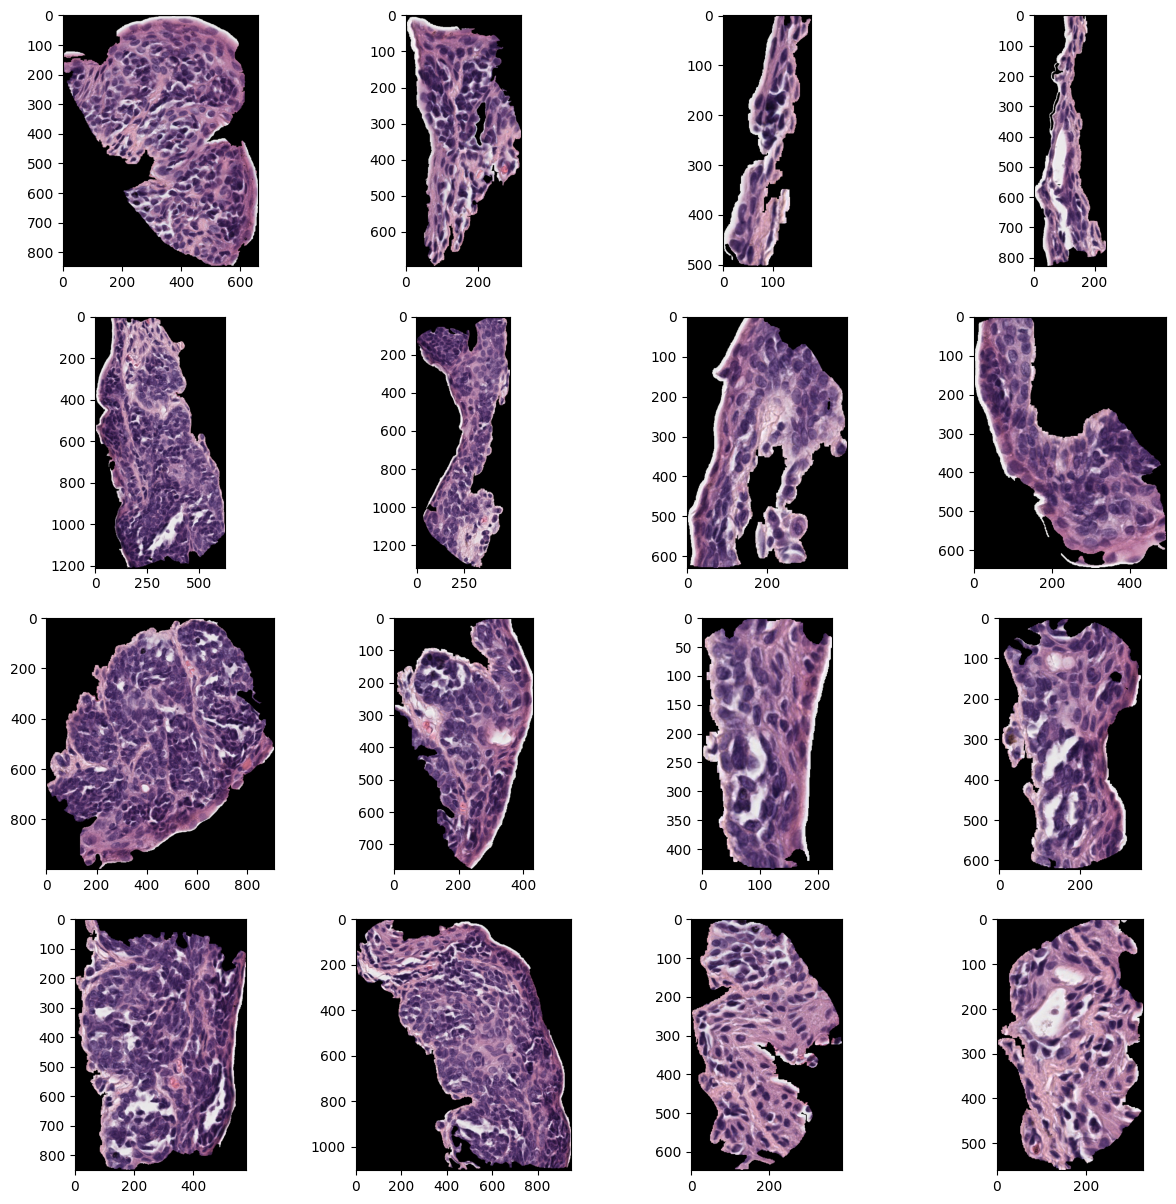

In [95]:
import fiona
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage import morphology

with fiona.open("cell_geo_small.geojson", "r") as geojson:
   features = [feature["geometry"] for feature in geojson]

fig, axs = plt.subplots(4, 4, figsize=(15, 15))
axs=axs.flatten()

with rasterio.open("h2114153  h&e_ROI_1 Epithelia.png") as src:
    for i,feature in enumerate(features):
            out_image,_=rasterio.mask.mask(src,[feature],crop=True)
            axs[i].imshow(out_image.transpose((1,2,0)))

Rather than trying to figure out the right package to use and what sort of logic we should use along with it, i feel it might be better to brute force coordinate generation, and then refine the logic we use to pick which squares to focus on and which we should leave out. The code below focuses on that logic

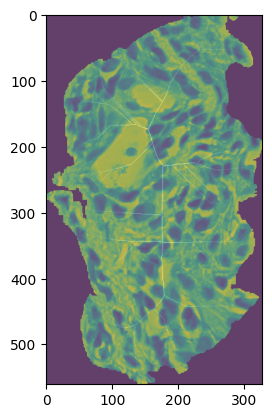

In [104]:
skel, distance = morphology.medial_axis(out_image.transpose(1, 2, 0)[:,:,0], return_distance=True)
dist_on_skel = distance * skel
plt.imshow(dist_on_skel, alpha = 0.5, cmap= plt.cm.gray)
plt.imshow(out_image.transpose(1, 2, 0)[:,:,0], alpha = 0.5)

In [85]:
morphology.skeletonize(out_image.transpose(1, 2, 0)[:,:,0])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

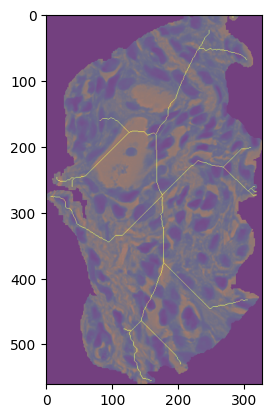

In [92]:
plt.imshow(out_image.transpose(1, 2, 0)[:,:,0], alpha = 0.5)
plt.imshow(morphology.skeletonize(out_image.transpose(1, 2, 0)[:,:,0], method = 'lee'), alpha = 0.5)

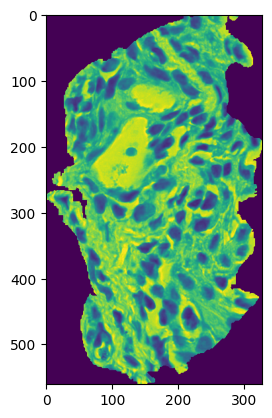

In [80]:
plt.imshow(out_image.transpose(1, 2, 0)[:,:,0])

In [59]:
plt.imshow(morphology.skeletonize(out_image.transpose(1, 2, 0)))

Error in callback <function _draw_all_if_interactive at 0x7e75c5ce3f60> (for post_execute):


ValueError: arrays must be of dtype byte, short, float32 or float64

ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 640x480 with 1 Axes>

In [44]:
skeleton = morphology.skeletonize(out_image)
skeleton

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [9]:
# This function will take in one of the features created above and generate a patch.
# I think having a rudimentary solution based on (brute force) would be better than trying to think up a way to create a patch from some obscure package we would
# have to research, etc. We should maybe ask the thinkers to figure out a way to smartly generate patches either using a package or some algorithm, as of right now, though
# creating some base solution would be better, I feel.
def initial_patches(feature):
    # Have patches be scaled to 1/16 of total feature by length of feature
    coordinates = np.array([x for xs in feature.coordinates for x in xs])
    x_min = coordinates[:,0].min()
    x_max = coordinates[:,0].max()
    y_min = coordinates[:,1].min()
    y_max = coordinates[:,1].max()
    patch_length = min(y_max - y_min, x_max - x_min) / 16

    # Start two patch lengths away from x_min coordinate y_max coordinate and create array
    # Array will contain the coordinates of top left part of square
    x = np.arange(x_min - 2*patch_length, x_max + 2*patch_length, patch_length)
    y = np.arange(y_max + 2*patch_length, y_min - 2*patch_length, -patch_length)

    x_grid, y_grid = np.meshgrid(x, y)
    patches = np.concatenate((x_grid.reshape(-1, 1), y_grid.reshape(-1, 1)), axis = 1)

    return patches

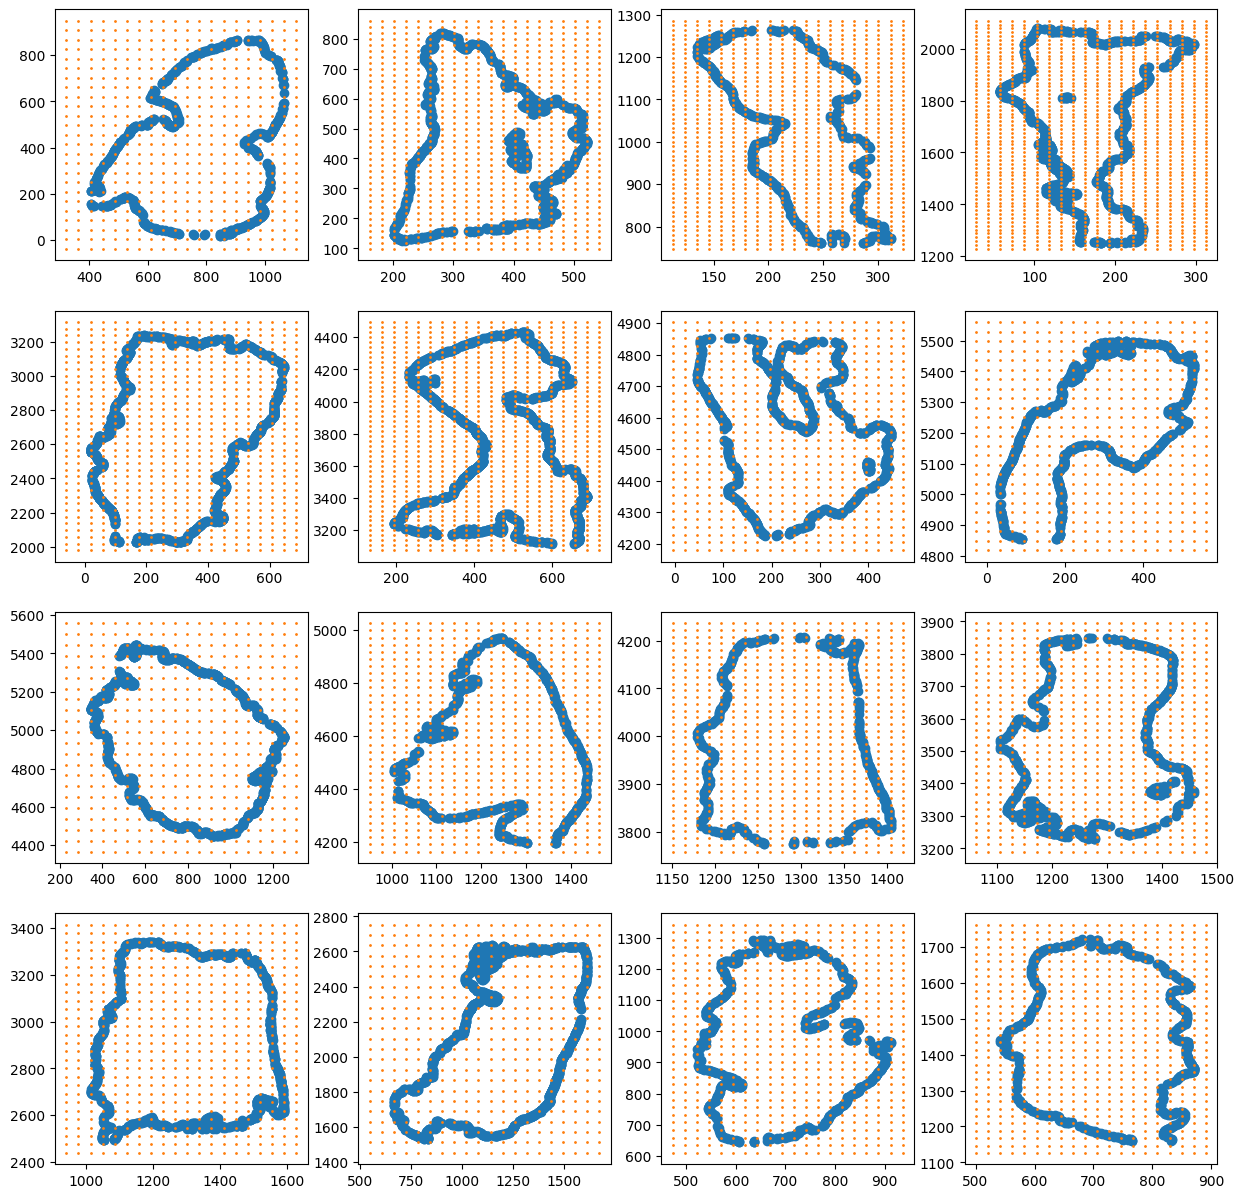

In [23]:
# Demonstration of code, needs some configuring if want to overlay dots on actual image
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
axs=axs.flatten()

for i, feature in enumerate(features):
  coordinates = np.array([x for xs in feature.coordinates for x in xs]).reshape(-1, 2)
  axs[i].scatter(coordinates[:,0], coordinates[:,1])
  axs[i].scatter(initial_patches(feature)[:,0], initial_patches(feature)[:,1], s = 1)

In [33]:
skeleton = morphology.skeletonize(rasterio.mask.mask)

AttributeError: 'function' object has no attribute 'astype'

In [11]:
coordinates

,0,1
0,765.0,1160.0
1,765.0,1163.0
2,763.0,1165.0
3,760.0,1165.0
4,760.0,1164.0
...,...,...
737,833.0,1164.0
738,833.0,1161.0
739,832.0,1161.0
740,832.0,1160.0


In [ ]:
# Choosing square logic
def choose_square(feature, patch_coords):
    #